In [173]:
from google.cloud import bigquery
from google.cloud import storage
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
from scipy.stats import chi2
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, ExtraTreeRegressor, ExtraTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from xgboost import XGBRegressor
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings("ignore") # Suppress all warnings
pd.options.display.float_format = '{:.2f}'.format

In [174]:
# Initialize BigQuery and Storage clients
bigquery_client = bigquery.Client()
storage_client = storage.Client()

print("Authentication successful!")
client = bigquery.Client()
storage_client = storage.Client()

Authentication successful!


In [175]:
gcs_uri="gs://samplebucketvrs/Intelligence Analytics/og4/NFLX.csv"

In [193]:
job_config = bigquery.LoadJobConfig(
    source_format=bigquery.SourceFormat.CSV,  # Change to PARQUET, JSON, etc., as needed
    skip_leading_rows=1,                      # Adjust if the file has headers
    autodetect=True                           # Automatically infer the schema
)
from google.cloud import bigquery

# Replace with your values
project_id = "Big-data-engin"  # Your Google Cloud Project ID
dataset_id = "Sample1"  # Your BigQuery Dataset ID
table_id = "stock"      # Your BigQuery Table ID

# Create a reference to the table
client = bigquery.Client()
dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
load_job = client.load_table_from_uri(
    gcs_uri, table_ref, job_config=job_config
)

# Wait for the job to complete
load_job.result()
print(f"Loaded {load_job.output_rows} rows into {dataset_id}.{table_id}.")

# Initialize the BigQuery client
client = bigquery.Client()

# Specify the table ID in the format `project_id.dataset_id.table_id`
table_id = "big-data-engin.Sample1.stock"  # Replace 'project_id' with your actual project ID

# Load the table into a pandas DataFrame
table = client.get_table(table_id)  # Fetch table metadata
df = client.list_rows(table).to_dataframe()  # Download table contents into a DataFrame

# Display the DataFrame
df.head(5)

Loaded 1009 rows into Sample1.stock.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-11-30,288.00,290.81,283.06,286.13,286.13,11860100
1,2019-11-04,288.00,295.39,287.16,292.86,292.86,5566200
2,2018-03-07,320.00,323.74,314.55,321.16,321.16,17132200
3,2019-03-11,352.00,358.98,350.03,358.86,358.86,5387300
4,2020-06-08,416.00,420.80,406.50,419.49,419.49,5851500


In [194]:
df.describe()
columns_to_drop = [col for col in df.columns if col.lower() == 'id']

if columns_to_drop:
    df = df.drop(columns=columns_to_drop)
# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [195]:
def detect_outliers_large(df, method="iqr", threshold=1.5):
    """
    Detect outliers in a large DataFrame using IQR or Z-score.
    """
    outliers = {}
    if method == "iqr":
        for col in df.select_dtypes(include=np.number).columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index.tolist()
    elif method == "zscore":
        for col in df.select_dtypes(include=np.number).columns:
            mean = df[col].mean()
            std = df[col].std()
            z_scores = (df[col] - mean) / std
            outliers[col] = df[abs(z_scores) > threshold].index.tolist()
    else:
        raise ValueError("Method must be 'iqr' or 'zscore'.")
    return outliers

def calculate_outlier_percentage(outliers_dict, total_rows):
    """
    Calculate the percentage of outliers for each column.
    """
    outlier_percentage = {}
    for col, outlier_indices in outliers_dict.items():
        outlier_percentage[col] = (len(outlier_indices) / total_rows) * 100
    return outlier_percentage

def clean_or_winsorize(df, outliers_dict, threshold=5):
    """
    Clean or apply Winsorization based on outlier percentage.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame.
        outliers_dict (dict): Dictionary with outliers.
        threshold (int): Percentage threshold to decide action.
    
    Returns:
        pd.DataFrame: Processed DataFrame.
    """
    df_processed = df.copy()
    total_rows = len(df)

    outlier_percentage = calculate_outlier_percentage(outliers_dict, total_rows)

    for col, percentage in outlier_percentage.items():
        if percentage <= threshold:
            # Remove outliers (clean the data)
            outlier_indices = outliers_dict[col]
            # Reset index and then drop
            df_processed = df_processed.reset_index(drop=True)
            df_processed.drop(index=outlier_indices, inplace=True, errors='ignore')
            print(f"Removed {percentage:.2f}% outliers from column '{col}'.")
        else:
            # Apply Winsorization
            df_processed[col] = df_processed[col].astype(float)
            df_processed[col] = winsorize(df_processed[col], limits=(0.05, 0.05))
            print(f"Applied Winsorization to column '{col}' with {percentage:.2f}% outliers.")

    return df_processed

# Example usage:
# Load dataset
# df = pd.read_csv("your_large_dataset.csv")
total_rows = len(df)
outliers_dict = detect_outliers_large(df, method="iqr", threshold=1.5)

# Process data based on outlier percentage
df_processed = clean_or_winsorize(df, outliers_dict, threshold=5)

# Save the processed dataset
# df_processed.to_csv("cleaned_dataset.csv", index=False)


Removed 0.00% outliers from column 'Open'.
Removed 0.00% outliers from column 'High'.
Removed 0.00% outliers from column 'Low'.
Removed 0.00% outliers from column 'Close'.
Removed 0.00% outliers from column 'Adj Close'.
Applied Winsorization to column 'Volume' with 5.65% outliers.


In [196]:
# Create a dictionary with column names as keys and unique counts as values
unique_counts = {col: df[col].nunique() for col in df.columns}

# Convert the dictionary into a pandas DataFrame
unique_counts_df = pd.DataFrame(list(unique_counts.items()), columns=['Column', 'Unique_Values'])

# Display the new DataFrame
print(unique_counts_df)

      Column  Unique_Values
0       Date           1009
1       Open            976
2       High            983
3        Low            989
4      Close            988
5  Adj Close            988
6     Volume           1005


In [197]:
def identify_column_type(df):
    column_types = []
    for col in df.columns:
        if pd.api.types.is_bool_dtype(df[col]):  # Check for Boolean columns first
            col_type = "Boolean"
        elif pd.api.types.is_numeric_dtype(df[col]):  # Check for numeric columns
            col_type = "Numerical"
        elif pd.api.types.is_categorical_dtype(df[col]) or df[col].dtype == 'object':  # Check for categorical columns
            col_type = "Categorical"
        elif pd.api.types.is_datetime64_any_dtype(df[col]):  # Check for datetime columns
            col_type = "Datetime"
        else:
            col_type = "Unknown"  # Any other type falls here
        column_types.append({'Column': col, 'Type': col_type})
    
    # Convert the list of dictionaries to a DataFrame
    column_types_df = pd.DataFrame(column_types)
    return column_types_df

# Identify column types
column_types_df = identify_column_type(df)
print(column_types_df)

      Column       Type
0       Date   Datetime
1       Open  Numerical
2       High  Numerical
3        Low  Numerical
4      Close  Numerical
5  Adj Close  Numerical
6     Volume  Numerical


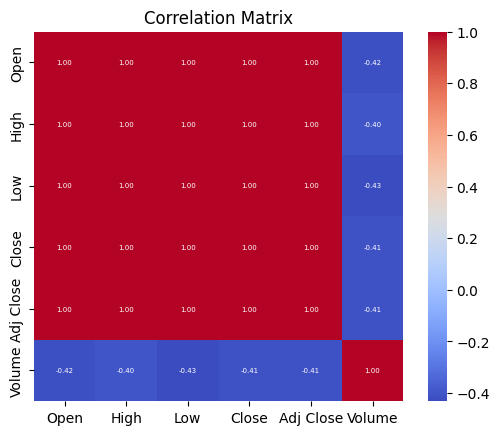

Highly Correlated Features:
    Feature_1  Feature_2  Correlation
0        Open       High         1.00
1        Open        Low         1.00
2        Open      Close         1.00
3        Open  Adj Close         1.00
4        Open     Volume        -0.42
5        High        Low         1.00
6        High      Close         1.00
7        High  Adj Close         1.00
8        High     Volume        -0.40
9         Low      Close         1.00
10        Low  Adj Close         1.00
11        Low     Volume        -0.43
12      Close  Adj Close         1.00
13      Close     Volume        -0.41
14  Adj Close     Volume        -0.41


In [198]:
# Select only numerical columns
numerical_columns = df.select_dtypes(include=["number"])

# Compute the correlation matrix
corr_matrix = numerical_columns.corr()

# Visualize the correlation matrix using a heatmap
sns.heatmap(corr_matrix,
    annot=True,  # Annotate each cell with the correlation value
    fmt=".2f",   # Format for the annotation
    cmap="coolwarm",  # Colormap
    square=True,  # Make cells square
    cbar_kws={"shrink": 1},  # Shrink the color bar
    annot_kws={"size": 5} # Adjust annotation font size)
           )
plt.title("Correlation Matrix")
plt.show()

# Set a threshold for high correlation
threshold = 0.2

# Find pairs of highly correlated features
high_corr_pairs = (
    corr_matrix
    .where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))  # Select upper triangle
    .stack()  # Convert to a Series
    .reset_index()  # Convert to DataFrame
)

# Rename columns for readability
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Filter based on the threshold
high_corr_pairs = high_corr_pairs[abs(high_corr_pairs['Correlation']) > threshold]

# Display the resulting DataFrame
print("Highly Correlated Features:")
print(high_corr_pairs)

NameError: name 'column_types_df' is not defined

In [200]:
# Sample 10% of the data for faster processing
sampled_df = df.sample(frac=0.9, random_state=42)

# Separate features (X) and target (y)
y = sampled_df["Open"]
X = sampled_df.drop(columns=["Open","Date"])

# Scale only numerical columns
numeric_cols = X.select_dtypes(include=["number"]).columns
scaler = StandardScaler()
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Determine if the task is regression or classification
if pd.api.types.is_numeric_dtype(y):
    # Regression Task
    model = ExtraTreesRegressor(random_state=42, n_jobs=-1, n_estimators=100)
    task_type = "Regression"
else:
    # Classification Task
    model = ExtraTreesClassifier(random_state=42, n_jobs=-1, n_estimators=100)
    task_type = "Classification"

# Train the appropriate model
model.fit(X_train, y_train)

# Get Feature Importances
feature_importances = model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
importance_df.head()

,Feature,Importance
0,High,0.26
1,Low,0.24
2,Close,0.27
3,Adj Close,0.23
4,Volume,0.00


In [201]:
def select_top_features(model, X, min_features=5):
    if not hasattr(model, "feature_importances_"):
        raise ValueError("Model does not support feature importances.")
    
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    total_features = len(importance_df)
    additional_features = math.ceil(0.6 * total_features)
    selected_features_count = min(len(X.columns), max(min_features, additional_features + min_features))
    
    selected_features = importance_df.head(selected_features_count)['Feature'].tolist()
    return selected_features

In [202]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, ExtraTreeClassifier, ExtraTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from xgboost import XGBRegressor
import pandas as pd

def select_top_features(model, X, min_features=5):
    if not hasattr(model, "feature_importances_"):
        raise ValueError("Model does not support feature importances.")
    
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    total_features = len(importance_df)
    additional_features = max(1, round(0.6 * total_features))
    selected_features_count = min(len(X.columns), max(min_features, additional_features + min_features))
    
    selected_features = importance_df.head(selected_features_count)['Feature'].tolist()
    return selected_features


def select_and_apply_model(X, y):
    # Normalize the features
    scaler = StandardScaler()
    X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    # Identify task type
    if pd.api.types.is_numeric_dtype(y):
        task_type = "regression"
    else:
        task_type = "classification"
    
    # Define models
    models = {
        "regression": {
            "LinearRegression": LinearRegression(),
            "Lasso": Lasso(alpha=0.1, random_state=42),
            "Ridge": Ridge(alpha=1.0, random_state=42),
            "DecisionTreeRegressor": DecisionTreeRegressor(),
            "ExtraTreeRegressor": ExtraTreeRegressor(),
            "RandomForestRegressor": RandomForestRegressor(n_estimators=100, random_state=42),
            "ExtraTreesRegressor": ExtraTreesRegressor(n_estimators=100, random_state=42),
            "AdaBoostRegressor": AdaBoostRegressor(n_estimators=50, random_state=42),
            "XGBRegressor": XGBRegressor(n_estimators=100, random_state=42)
        },
        "classification": {
            "LogisticRegression": LogisticRegression(max_iter=200, random_state=42),
            "RidgeClassifier": RidgeClassifier(),
            "DecisionTreeClassifier": DecisionTreeClassifier(),
            "ExtraTreeClassifier": ExtraTreeClassifier(),
            "KNeighborsClassifier": KNeighborsClassifier(),
            "RadiusNeighborsClassifier": RadiusNeighborsClassifier(),
            "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
            "ExtraTreesClassifier": ExtraTreesClassifier(n_estimators=100, random_state=42)
        }
    }
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
    results = {}
    final_selected_features = None
    
    # Model evaluation
    for model_name, model in models[task_type].items():
        model.fit(X_train, y_train)
        
        if hasattr(model, "feature_importances_"):
            selected_features = select_top_features(model, X)
            X_train_selected = X_train[selected_features]
            X_test_selected = X_test[selected_features]
        else:
            selected_features = list(X_train.columns)
            X_train_selected = X_train
            X_test_selected = X_test
        
        model.fit(X_train_selected, y_train)
        score = model.score(X_test_selected, y_test)
        results[model_name] = score
        
        if results[model_name] == max(results.values()):
            final_selected_features = selected_features

    # Select the best model
    best_model_name = max(results, key=results.get)
    best_model_score = results[best_model_name]
    best_model = models[task_type][best_model_name]
    
    print(f"Best {task_type} model: {best_model_name} with score: {best_model_score:.4f}")
    print(f"Selected Features: {final_selected_features}")
    return best_model, best_model_name, best_model_score, final_selected_features


# Example usage
y = sampled_df["Open"]
X = sampled_df.drop(columns=["Open","Date"])
best_model, model_name, model_score, top_features = select_and_apply_model(X, y)


Best regression model: ExtraTreesRegressor with score: 0.9995
Selected Features: ['Close', 'High', 'Low', 'Adj Close', 'Volume']


In [203]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(best_model, X[top_features], y, cv=5, scoring='r2')
print(f"Cross-Validation R^2 Scores: {cv_scores}")
print(f"Mean CV R^2 Score: {cv_scores.mean():.4f}")


Cross-Validation R^2 Scores: [0.99942524 0.99933213 0.99966509 0.999322   0.99937871]
Mean CV R^2 Score: 0.9994


In [204]:
# Predict on the dataset
sampled_df['Predictions'] = best_model.predict(sampled_df[top_features])

# Group by artificial weekly and monthly intervals
weekly_data = predict_intervals_no_date(best_model, sampled_df, top_features, interval_size=7, interval_name="Week")
monthly_data = predict_intervals_no_date(best_model, sampled_df, top_features, interval_size=30, interval_name="Month")


In [3]:
"""import matplotlib.pyplot as plt

def plot_actual_vs_predicted(weekly_data, monthly_data):
    
    #Plot Actual vs Predicted values for weekly and monthly intervals.
    
    fig, axes = plt.subplots(2, 1, figsize=(12, 12))
    fig.suptitle("Actual vs Predicted Values", fontsize=16)
    
    # Weekly plot
    axes[0].plot(weekly_data.index, weekly_data['Target'], label='Actual', marker='o')
    axes[0].plot(weekly_data.index, weekly_data['Predictions'], label='Predicted', marker='x')
    axes[0].set_title("Weekly Predictions")
    axes[0].set_xlabel("Week")
    axes[0].set_ylabel("Values")
    axes[0].legend()
    axes[0].grid()
    
    # Monthly plot
    axes[1].plot(monthly_data.index, monthly_data['Target'], label='Actual', marker='o')
    axes[1].plot(monthly_data.index, monthly_data['Predictions'], label='Predicted', marker='x')
    axes[1].set_title("Monthly Predictions")
    axes[1].set_xlabel("Month")
    axes[1].set_ylabel("Values")
    axes[1].legend()
    axes[1].grid()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Leave space for the main title
    plt.show()
plot_actual_vs_predicted(weekly_data, monthly_data)
"""

'import matplotlib.pyplot as plt\n\ndef plot_actual_vs_predicted(weekly_data, monthly_data):\n    \n    #Plot Actual vs Predicted values for weekly and monthly intervals.\n    \n    fig, axes = plt.subplots(2, 1, figsize=(12, 12))\n    fig.suptitle("Actual vs Predicted Values", fontsize=16)\n    \n    # Weekly plot\n    axes[0].plot(weekly_data.index, weekly_data[\'Target\'], label=\'Actual\', marker=\'o\')\n    axes[0].plot(weekly_data.index, weekly_data[\'Predictions\'], label=\'Predicted\', marker=\'x\')\n    axes[0].set_title("Weekly Predictions")\n    axes[0].set_xlabel("Week")\n    axes[0].set_ylabel("Values")\n    axes[0].legend()\n    axes[0].grid()\n    \n    # Monthly plot\n    axes[1].plot(monthly_data.index, monthly_data[\'Target\'], label=\'Actual\', marker=\'o\')\n    axes[1].plot(monthly_data.index, monthly_data[\'Predictions\'], label=\'Predicted\', marker=\'x\')\n    axes[1].set_title("Monthly Predictions")\n    axes[1].set_xlabel("Month")\n    axes[1].set_ylabel("Valu

In [2]:
"""def plot_trends(data, interval_name, y_column, title):
    
    #Plot prediction trends over weekly or monthly intervals.
    
    plt.figure(figsize=(10, 6))
    plt.plot(data[interval_name], data[y_column], marker='o', label=f'{y_column} Trend')
    plt.title(title)
    plt.xlabel(interval_name)
    plt.ylabel(y_column)
    plt.grid()
    plt.legend()
    plt.show()
# Assuming `weekly_data` and `monthly_data` have 'Predictions' as the predicted column.
# Ensure 'interval_name' (e.g., "Week", "Month") is passed along with 'y_column' and 'title'.

# Plot trends for weekly data
plot_trends(weekly_data.reset_index(), "Week", "Predictions", "Weekly Prediction Trends")

# Plot trends for monthly data
plot_trends(monthly_data.reset_index(), "Month", "Predictions", "Monthly Prediction Trends")
"""

'def plot_trends(data, interval_name, y_column, title):\n    \n    #Plot prediction trends over weekly or monthly intervals.\n    \n    plt.figure(figsize=(10, 6))\n    plt.plot(data[interval_name], data[y_column], marker=\'o\', label=f\'{y_column} Trend\')\n    plt.title(title)\n    plt.xlabel(interval_name)\n    plt.ylabel(y_column)\n    plt.grid()\n    plt.legend()\n    plt.show()\n# Assuming `weekly_data` and `monthly_data` have \'Predictions\' as the predicted column.\n# Ensure \'interval_name\' (e.g., "Week", "Month") is passed along with \'y_column\' and \'title\'.\n\n# Plot trends for weekly data\nplot_trends(weekly_data.reset_index(), "Week", "Predictions", "Weekly Prediction Trends")\n\n# Plot trends for monthly data\nplot_trends(monthly_data.reset_index(), "Month", "Predictions", "Monthly Prediction Trends")\n'

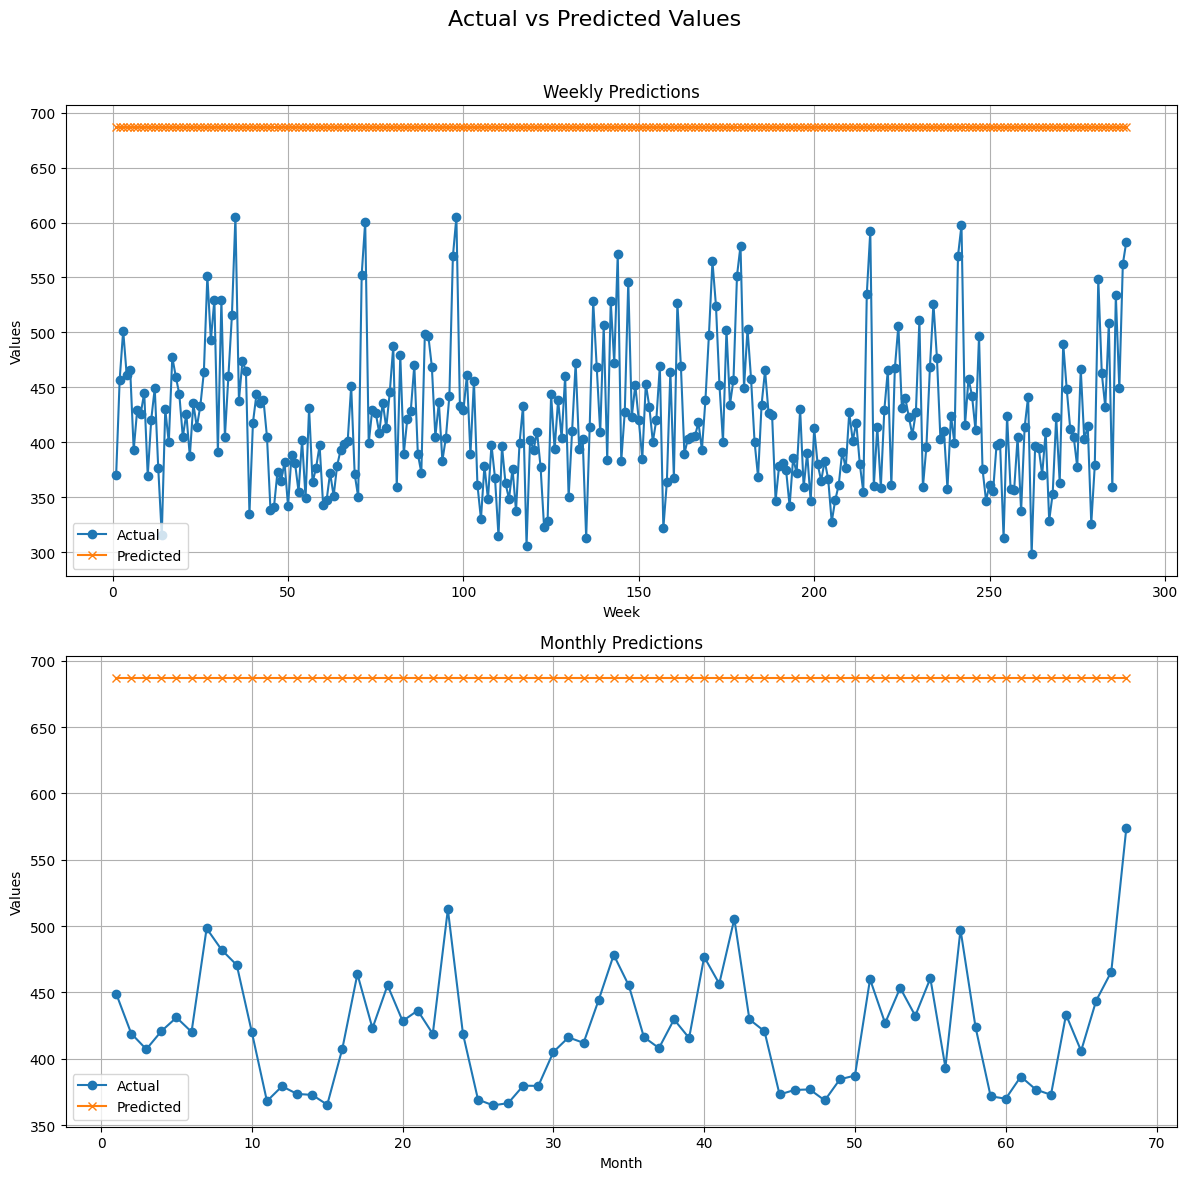

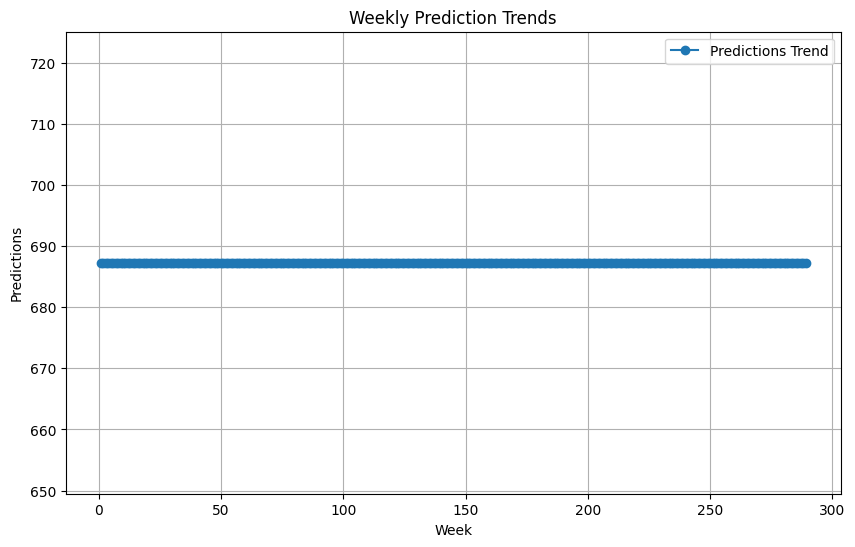

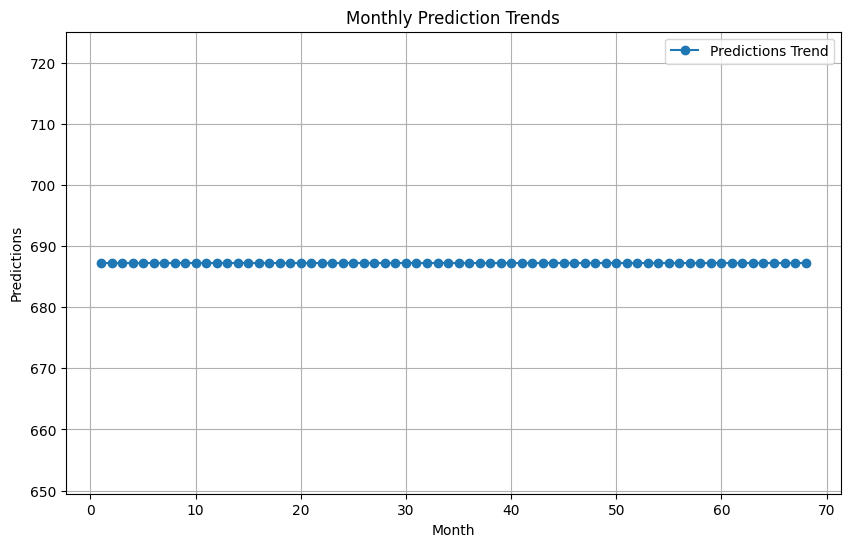

In [207]:
import pandas as pd
import numpy as np

def create_intervals(X, y, interval_size, interval_name):
    """
    Create intervals (weekly/monthly) by grouping rows.
    """
    # Combine features and target for grouping
    data = X.copy()
    data['Target'] = y

    # Create interval index
    data[interval_name] = (data.index // interval_size) + 1

    # Aggregate features and target for intervals
    aggregated_data = data.groupby(interval_name).mean()
    return aggregated_data

def predict_intervals_no_date(model, X, selected_features, interval_size, interval_name):
    """
    Predict for weekly or monthly intervals without date/time column.
    """
    # Create intervals
    aggregated_data = create_intervals(X, y, interval_size, interval_name)

    # Predict for the intervals using selected features
    predictions = model.predict(aggregated_data[selected_features])
    aggregated_data['Predictions'] = predictions

    return aggregated_data

# Example usage:
interval_name_weekly = "Week"
interval_name_monthly = "Month"

# Weekly predictions
weekly_data = predict_intervals_no_date(best_model, sampled_df, top_features, interval_size=7, interval_name=interval_name_weekly)

# Monthly predictions
monthly_data = predict_intervals_no_date(best_model, sampled_df, top_features, interval_size=30, interval_name=interval_name_monthly)

# Visualize results (similar as before)
plot_actual_vs_predicted(weekly_data, monthly_data)
plot_trends(weekly_data.reset_index(), interval_name_weekly, "Predictions", "Weekly Prediction Trends")
plot_trends(monthly_data.reset_index(), interval_name_monthly, "Predictions", "Monthly Prediction Trends")


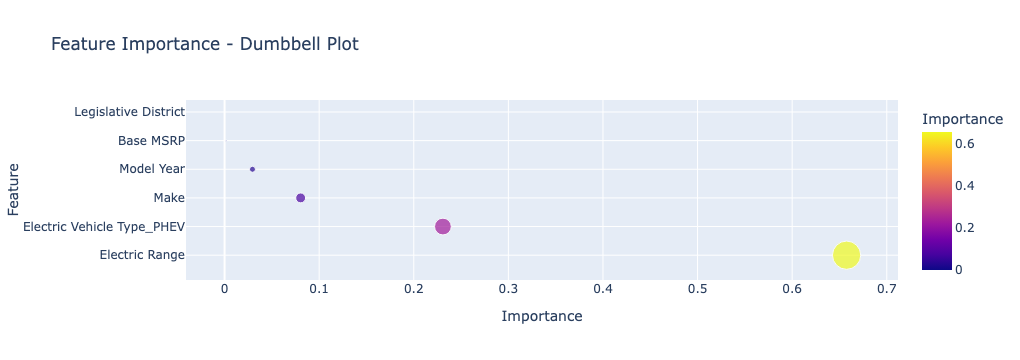

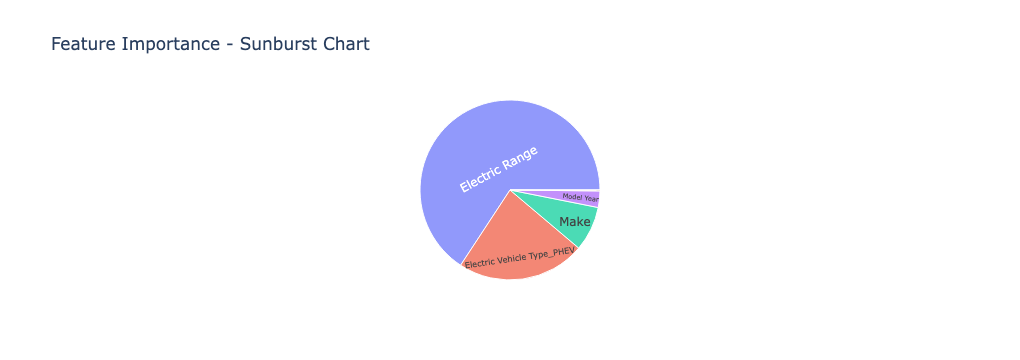

In [172]:
import os

# Folder to save the plots
save_folder = "saved_figures"

os.makedirs(save_folder, exist_ok=True)
# Sort data by importance
extra_trees_importance_df = extra_trees_importance_df.sort_values('Importance', ascending=False)

# Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(extra_trees_importance_df['Feature'], extra_trees_importance_df['Importance'], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Bar Chart')
plt.tight_layout()
plt.savefig(f"{save_folder}/bar_chart.png")
plt.close()
plt.show()

# Horizontal Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(extra_trees_importance_df['Feature'], extra_trees_importance_df['Importance'], color='lightcoral')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Horizontal Bar Chart')
plt.gca().invert_yaxis()  # Invert y-axis to show the highest importance at the top
plt.tight_layout()
plt.savefig(f"{save_folder}/horizontal_bar_chart.png")
plt.close()
plt.show()

# Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(
    extra_trees_importance_df['Importance'],
    labels=extra_trees_importance_df['Feature'],
    autopct='%1.1f%%',
    colors=plt.cm.Paired.colors,
    startangle=90,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'} 
)
plt.title('Feature Importance - Pie Chart')
plt.tight_layout()
plt.savefig(f"{save_folder}/Pie_Chart_chart.png")
plt.close()
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(extra_trees_importance_df['Feature'], extra_trees_importance_df['Importance'], color='purple')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Scatter Plot')
plt.tight_layout()
plt.savefig(f"{save_folder}/Scatter_plot_chart.png")
plt.close()
plt.show()

# Add a cumulative importance column
extra_trees_importance_df = extra_trees_importance_df.sort_values('Importance', ascending=False)
extra_trees_importance_df['Cumulative Importance'] = extra_trees_importance_df['Importance'].cumsum()

# Line Chart
plt.figure(figsize=(10, 6))
plt.plot(extra_trees_importance_df['Feature'], extra_trees_importance_df['Cumulative Importance'], marker='o', linestyle='--', color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Cumulative Importance')
plt.title('Feature Importance - Cumulative Line Chart')
plt.tight_layout()
plt.savefig(f"{save_folder}/line_Chart_chart.png")
plt.close()
plt.show()

# Bubble Chart
plt.figure(figsize=(10, 6))
plt.scatter(
    extra_trees_importance_df['Feature'],
    extra_trees_importance_df['Importance'],
    s=extra_trees_importance_df['Importance'] * 1000,  # Bubble size
    alpha=0.5,
    color='blue'
)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Bubble Chart')
plt.tight_layout()
plt.savefig(f"{save_folder}/bubble_Chart_chart.png")
plt.close()
plt.show()

import plotly.express as px

# Dumbbell Plot using Plotly
fig = px.scatter(extra_trees_importance_df, x='Importance', y='Feature', size='Importance', color='Importance', 
                 title="Feature Importance - Dumbbell Plot", orientation='h')
fig.update_traces(marker=dict(opacity=0.7))
fig.show()

# Stacked Bar Chart
import numpy as np

extra_trees_importance_df = extra_trees_importance_df.sort_values('Importance', ascending=False)
cumulative_importance = np.cumsum(extra_trees_importance_df['Importance'])

plt.figure(figsize=(10, 6))
plt.bar(extra_trees_importance_df['Feature'], extra_trees_importance_df['Importance'], color='skyblue', label='Feature Importance')
plt.plot(extra_trees_importance_df['Feature'], cumulative_importance, marker='o', color='red', label='Cumulative Importance')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Stacked Bar Chart with Cumulative Importance')
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_folder}/stacked_Chart_chart.png")
plt.close()
plt.show()

import seaborn as sns

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(data=extra_trees_importance_df, x='Feature', y='Importance', palette='muted')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Violin Plot')
plt.tight_layout()
plt.savefig(f"{save_folder}/violin_Chart_chart.png")
plt.close()
plt.show()

# Polar Chart
angles = np.linspace(0, 2 * np.pi, len(extra_trees_importance_df), endpoint=False).tolist()
values = extra_trees_importance_df['Importance'].tolist()

# Close the plot
angles += angles[:1]
values += values[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'polar': True})
ax.fill(angles, values, color='blue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)
ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(extra_trees_importance_df['Feature'], rotation=45, ha='right')
ax.set_title('Feature Importance - Polar Chart')
plt.tight_layout()
plt.savefig(f"{save_folder}/polar_Chart_chart.png")
plt.close()
plt.show()

import plotly.express as px

# Sunburst Chart
fig = px.sunburst(
    data_frame=extra_trees_importance_df,
    path=['Feature'],  # Hierarchical path (use feature names)
    values='Importance',  # Size of each segment
    title='Feature Importance - Sunburst Chart'
)
fig.show()

# Lollipop Chart without `use_line_collection`
plt.figure(figsize=(10, 6))
plt.stem(extra_trees_importance_df['Feature'], extra_trees_importance_df['Importance'], basefmt=" ")
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Lollipop Chart')
plt.tight_layout()
plt.savefig(f"{save_folder}/lollipop_Chart_chart.png")
plt.close()
plt.show()

# Dummy data for grouping (e.g., two sets of importance scores)
extra_trees_importance_df['Group1'] = extra_trees_importance_df['Importance'] * 1.1
extra_trees_importance_df['Group2'] = extra_trees_importance_df['Importance'] * 0.9

# Dumbbell Chart
plt.figure(figsize=(10, 6))
for i in range(len(extra_trees_importance_df)):
    plt.plot([extra_trees_importance_df['Group1'][i], extra_trees_importance_df['Group2'][i]], [i, i], color='gray')
plt.scatter(extra_trees_importance_df['Group1'], range(len(extra_trees_importance_df)), color='red', label='Group 1')
plt.scatter(extra_trees_importance_df['Group2'], range(len(extra_trees_importance_df)), color='blue', label='Group 2')
plt.yticks(range(len(extra_trees_importance_df)), extra_trees_importance_df['Feature'])
plt.xlabel('Importance')
plt.title('Feature Importance - Dumbbell Chart')
plt.legend()
plt.tight_layout()
plt.savefig(f"{save_folder}/Dumbell_Chart_chart.png")
plt.close()
plt.show()


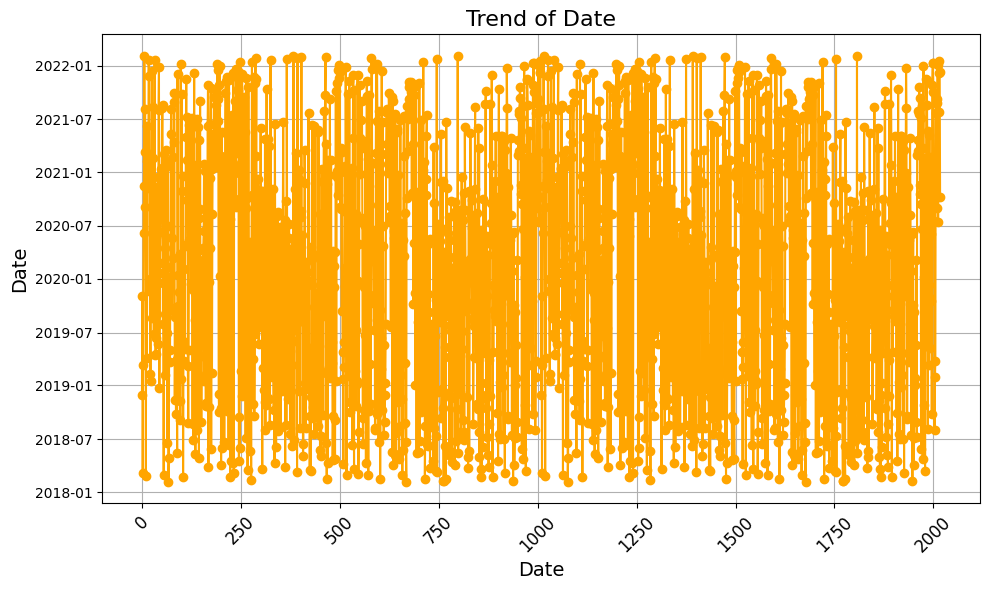

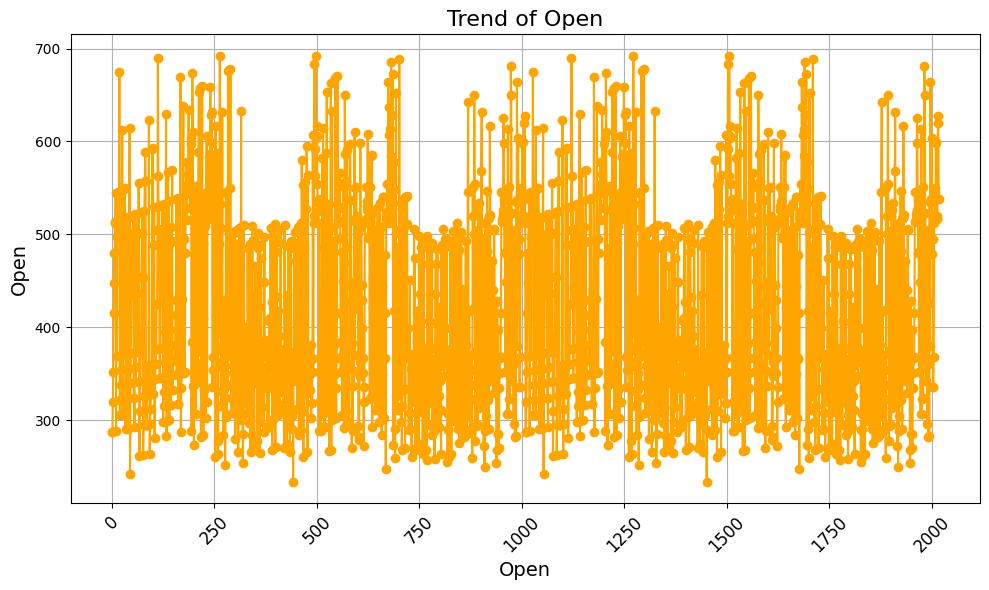

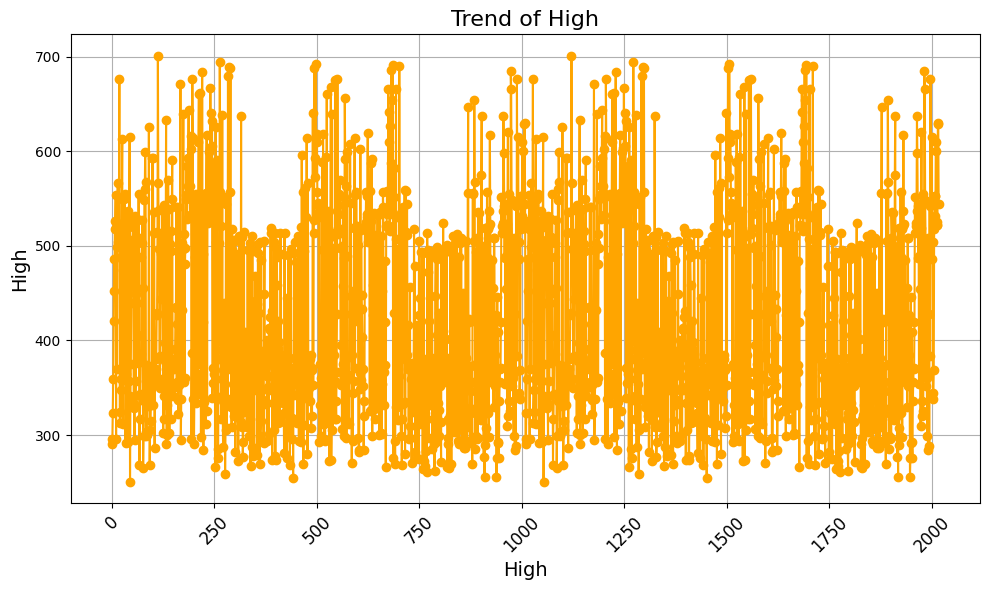

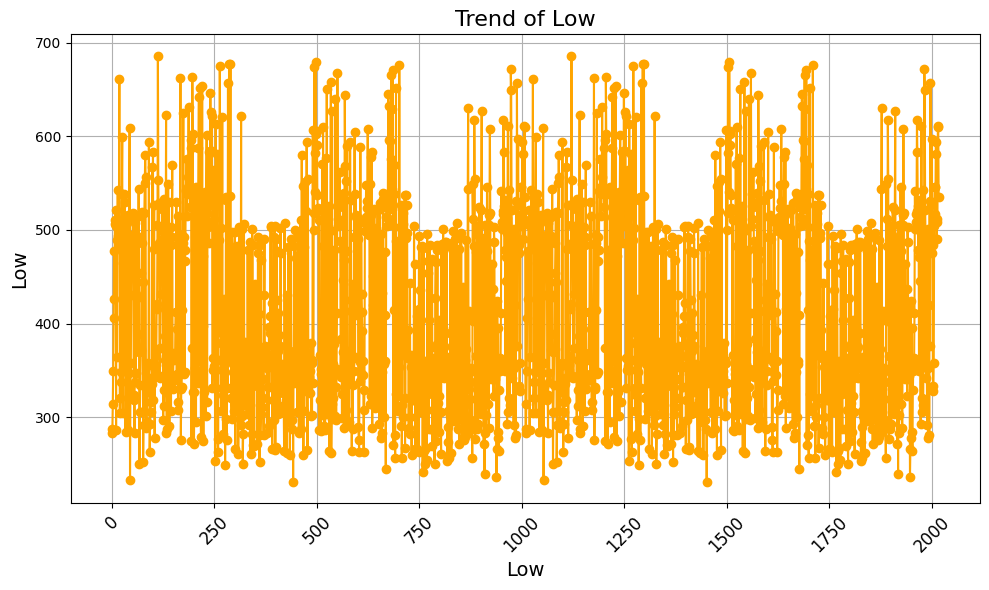

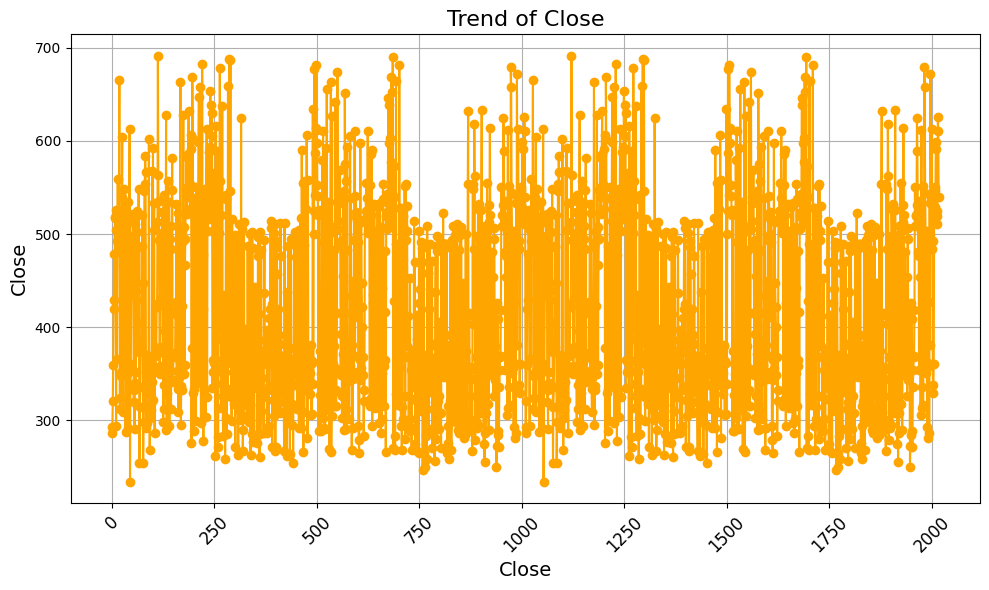

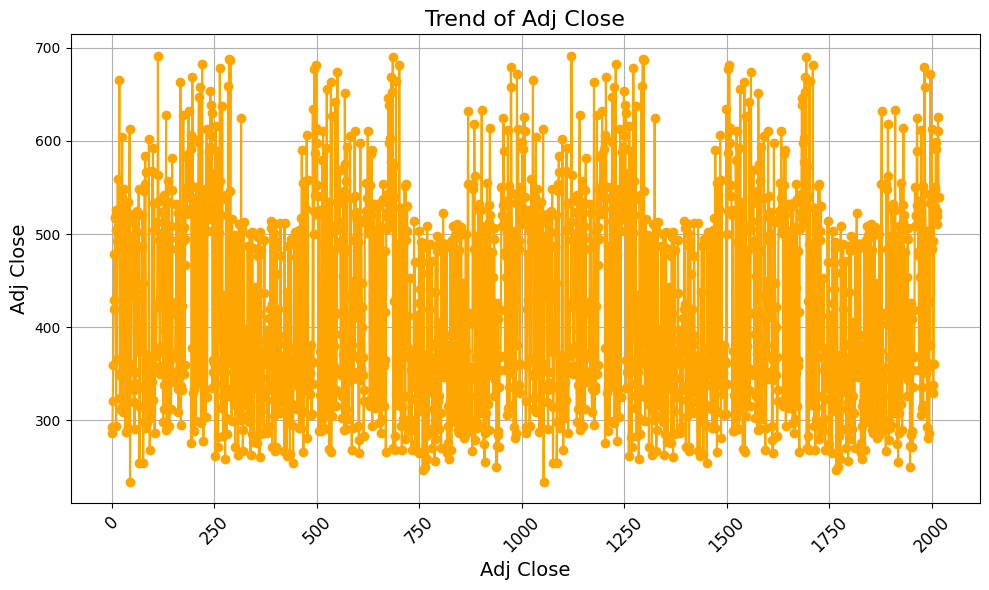

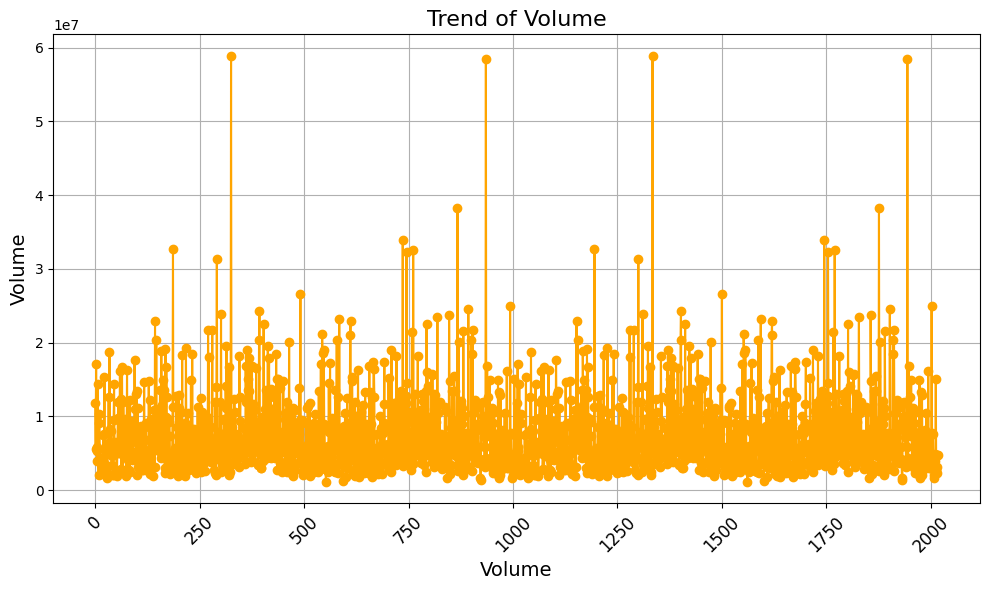

In [208]:
# Generate charts dynamically based on column type
def create_charts(df):
    for column in df.columns:
        plt.figure(figsize=(10, 6))
        
        if df[column].dtype == 'object' or df[column].nunique() < 10:  # Categorical columns
            df[column].value_counts().plot(kind='bar', color='skyblue')
            plt.title(f"Distribution of {column}", fontsize=16)
            plt.ylabel("Frequency", fontsize=14)
        
        else:  # Numerical columns
            plt.plot(df.index, df[column], marker='o', linestyle='-', color='orange')
            plt.title(f"Trend of {column}", fontsize=16)
            plt.ylabel(column, fontsize=14)
            plt.grid(True)
        
        plt.xlabel(column, fontsize=14)
        plt.xticks(rotation=45, fontsize=12)
        plt.tight_layout()
        plt.show()

# Call the function
create_charts(df)

In [71]:
def save_and_upload_all_figures(bucket_name, folder_path):
    # Authenticate with GCP
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    
    # Loop through all open figures
    for fig_num in plt.get_fignums():
        fig = plt.figure(fig_num)
        fig_name = f"figure_{fig_num}.png"  # Name each figure sequentially
        local_path = f"./{fig_name}"  # Save locally
        
        # Save figure
        fig.savefig(local_path)
        print(f"Saved {local_path}")
        
        # Upload to GCS
        blob = bucket.blob(f"{folder_path}/{fig_name}")
        blob.upload_from_filename(local_path)
        print(f"Uploaded {fig_name} to gs://{bucket_name}/{folder_path}/")
        
        # Optional: Remove local file after upload to save disk space
        os.remove(local_path)
        print(f"Removed local file {local_path}")

# Example usage
bucket_name = "samplebucketvrs"
folder_path = "Intelligence Analytics/og2"
save_and_upload_all_figures(bucket_name, folder_path)

In [73]:
bucket_name = "samplebucketvrs"
folder_path = "Intelligence Analytics/og2"
save_and_upload_all_figures(bucket_name, folder_path)

In [66]:
#!pip install matplotlib google-cloud-storage


In [21]:

# Function to upload files
def upload_to_gcs(bucket_name, folder_path, local_folder):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    for file_name in os.listdir(local_folder):
        local_file_path = os.path.join(local_folder, file_name)
        if os.path.isfile(local_file_path):
            blob = bucket.blob(f"{folder_path}/{file_name}")
            blob.upload_from_filename(local_file_path)
            print(f"Uploaded {file_name} to gs://{bucket_name}/{folder_path}/")

# Set your GCS bucket and folder path
bucket_name = "samplebucketvrs"
folder_path = "Intelligence Analytics/og2"

# Call the function
upload_to_gcs(bucket_name, folder_path, save_folder)


Uploaded horizontal_bar_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded stacked_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded violin_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded bar_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded lollipop_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded Pie_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded Scatter_plot_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded polar_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded line_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded bubble_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
Uploaded Dumbell_Chart_chart.png to gs://samplebucketvrs/Intelligence Analytics/og2/
